In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import xgboost as xgb 
from sklearn.model_selection import TimeSeriesSplit
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)
from sklearn.model_selection import cross_val_score
import seaborn as sns
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=2)

In [2]:
train = pd.read_csv('train.csv', parse_dates=['Дата транзакции'])
test = pd.read_csv('example.csv', parse_dates=['Дата транзакции'])
tariff = pd.read_csv('Тарифы 2019-2020.csv')  #БЕ №5
contragent = pd.read_csv('Контрагенты по годам.csv') #БЕ №5
ora = pd.read_csv('Покупка с ОРЭ 2019-2020.csv')#БЕ №3
valid_res = pd.read_excel('1кв2021_1.xlsx')

In [3]:
# приведем к нужному временному формату дату
for i in range(valid_res.shape[0]):
    date=valid_res.iloc[i,2]
    date = date.replace('.','')
    revdate = date[4:]+'-'+date[2:4]+'-'+date[0:2]
    valid_res.iloc[i,2]=revdate

In [4]:
# приведенная ниже функция строит график движения денежных средств
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

### Платежи бизнес юнитам (в дальнейшем б.ю.) осуществляются в дисциплинно платежные дни, которые зафиксированы. Наша цель для каждого б.ю. было определить эти дни. 

### Ниже мы выбросили все мелкие платежи, которые меньше 150 тыс. руб. Это не повлияет на точность, поскольку платежи такие осуществляются редко

In [5]:
zero_inedx = []
for i in range(train.shape[0]):
    if train.iloc[i,2] > -150000:
        zero_inedx.append(i)
train.drop(train.index[zero_inedx], inplace=True)

### Проанализировав датасет train, мы отметили что для всех б.ю. платежи осуществляются в фиксированный день недели. Но возможны исключения. Так если на этот день выпадает праздник, то платеж передвигается в зависимости от специфики б.ю.  

### Ниже приведена функция AlignData, которая проходит по датам платежа и записывает все платежи, как если бы они проводились в один день недели

In [6]:
def AlignData(be):
    startIdx = 0
    train_part = train[train['БЕ']==be]
    train_part.drop(['БЕ'], axis=1, inplace=True)
    train_align = pd.DataFrame(columns=['Дата транзакции', 'Сумма в RUB'])
    prev = train_part.iloc[startIdx,0]
    train_align=train_align.append(train_part.iloc[0])
    ind = 1; indAlign = 1
    while ind < train_part.shape[0]:
        # ниже мы рассматриваем разницу в днях 
        if train_part.iloc[ind,0] - prev == timedelta(days=7):
            prev = train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=8):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev = train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=4):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev = train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=9):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev=train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=6):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev=train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=5):
            train_part.iloc[ind,0]=prev+timedelta(days=7)
            prev=train_part.iloc[ind,0]
            train_align = train_align.append(train_part.iloc[ind])
            ind += 1; indAlign += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=1):#for bu=2
            train_align.iloc[indAlign-1,1] += train_part.iloc[ind,1] 
            ind += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=2):#for bu=2
            train_align.iloc[indAlign-1,1] += train_part.iloc[ind,1] 
            ind += 1
        elif train_part.iloc[ind,0] - prev == timedelta(days=0):
            train_align.iloc[indAlign-1,1] += train_part.iloc[ind,1] 
            ind += 1
        # change
        elif train_part.iloc[ind,0] - prev < timedelta(days=0):
            ind += 1
        else :
            train_align=train_align.append(pd.DataFrame([[prev+timedelta(days=7), 0]], columns=['Дата транзакции', 'Сумма в RUB']), ignore_index=True)
            prev=prev+timedelta(days=7)
            indAlign += 1
    train_align = train_align.set_index('Дата транзакции')
    return train_align

### Цель: построить предсказания для 5 и 3 б.ю., учитывая дополнительные данные и сравнить с построенными моделями. Таким образом, ответить на вопрос: "могут ли предоставленные дополнительные данные о БЕ номер 3 и 5 помочь улучшить точность моделей?" 

### Для предсказаний будем использовать авторегрессионную модель на временных рядах. В качестве признаков будем использовать количество лагов (предыдущих значений) целевой переменной. Предсказывать будем рекурсивно

In [7]:
class ARModel:
    def __init__(self, window, model):
        self.window = window
        self.model = model
    
    def fit(self, path):
        n = path.strides[0]
        X = np.lib.stride_tricks.as_strided(
            path,
            shape=(path.shape[0], self.window),
            strides=(n, n),
        )[:-self.window]
        Y = path[self.window:]
        self.history = path[-self.window:].reshape(1, -1)
        self.model.fit(X, Y)
        
    def forecast(self, steps):
        history = self.history.copy()
        predictions = np.empty(steps)
        
        for i in range(steps):
            y_pred = self.model.predict(history)[0]    
            predictions[i] = y_pred
            
            history[0, :-1] = history[0, 1:]
            history[0, -1] = y_pred

        return predictions

In [8]:
modelXGB = ARModel(
    window=24,
    model=Pipeline([
        ('scaler', StandardScaler()),
        ('ar_model', XGBRegressor(random_state=42)),
    ])
)

In [9]:
modelLin = ARModel(
    window=24,
    model=Pipeline([
        ('scaler', StandardScaler()),
        ('ar_model', LinearRegression()),
    ])
)

In [10]:
#Ниже функция осуществляет предобработку данных - добавляет лаги.
#Также она делит выборку на тренировочную и тестовую, чтобы определить ошибку и сравнить графически.
def prepareData(data, lag_start=1, lag_end=10,test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, y_train, X_test, y_test

In [11]:
# функция для построения графика
def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [12]:
# функция, которая предсказывает значения модели и строит график
def plotModelResults(model, X_train, X_test,y_test,y_train, plot_intervals=False, plot_anomalies=False, scale=1.96, y_pred=[], plot=True):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    error = mean_absolute_error(prediction, y_test)
    prediction = np.append(prediction, y_pred)
    if plot:
        plt.figure(figsize=(15, 7))
        plt.plot(prediction, "g", label="prediction", linewidth=2.0)
        plt.plot(y_test.values, label="actual", linewidth=2.0)
        if plot_intervals:
            cv = cross_val_score(model, X_train, y_train, 
                                        cv=tscv, 
                                        scoring="neg_mean_squared_error")
            deviation = np.sqrt(cv.std())

            lower = prediction - (scale * deviation)
            upper = prediction + (scale * deviation)

            plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
            plt.plot(upper, "r--", alpha=0.5)

            if plot_anomalies:
                anomalies = np.array([np.NaN]*len(y_test))
                anomalies[y_test<lower] = y_test[y_test<lower]
                anomalies[y_test>upper] = y_test[y_test>upper]
                plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

        plt.title("mean_absolute_error {}".format(error))
        plt.legend(loc="best")
        plt.tight_layout()
        plt.grid(True);
    return error

### Предсказния будем строить для двух кварталов. Это приблизительно 26 недель. Учитывая, что у нас почти для всех б.ю. (кроме 3) один платеж в неделю, нам нужно сделать предсказания для 26 значений. 

In [13]:
# параметрами данной функции есть:
# lag - количество лагов, используемых в модели
# cnt - на сколько дней сделать предсказания 
def MakePlotswithPrediction(train_align,model, lag=12, cnt=26, plot=True):
    lag_start=1
    lag_end=lag
    cntpred = cnt
    X_train, y_train, X_test, y_test = prepareData(data=train_align,lag_start=1, lag_end=lag_end,test_size=0)
    
    X_train_scaled = scaler.fit_transform(X_train)

    y1_pred = y_train[-1:]
    y_pred = []
    X_test = pd.DataFrame(X_train[-1:].copy())    
    for _ in range(cntpred):
        for i in range(lag_end-2, lag_start-1,-1):
            X_test.iloc[0,i]=X_test.iloc[0,i-1]
        X_test.iloc[0,0]=y1_pred
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y1_pred = model.predict(X_test)[0]
        y_pred.append(y1_pred)

    X_train, y_train, X_test, y_test = prepareData(data=train_align,lag_start=1, lag_end=lag_end,test_size=0.20)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)

    error = plotModelResults(model, X_train=X_train_scaled, X_test=X_test_scaled,y_test=y_test,y_train=y_train, plot_intervals=True, y_pred=y_pred, plot=plot)
    #plotCoefficients(model, X_train=X_train)
    return y_pred, error

In [14]:
# функция, чтобы сформировать датасет с предсказаниями
# startWeekday - параметр, указывающий в какой день недели осуществляется платеж
# 1-понельник, 2- вторник, 3- среда, 4-четверг, 5-пятница
def MergeVal(y_pred, bu, startWeekday=3):
    prev = pd.to_datetime('2021-01-1'+str(startWeekday)) # среда
    dfres = pd.DataFrame(columns=['date','sum', 'month', 'bu'])
    for i in range(len(y_pred)): # предсказывание на 26 недель
        dfres = dfres.append(pd.DataFrame([[prev,y_pred[i],prev.month,bu]], columns=['date', 'sum','month','bu']), ignore_index=True)
        prev = prev + timedelta(days=7)
    #занулим выходные
    dfres.iloc[16,1]=0
    #если расчетный день - вторник, то стоит учесть праздник 23 и перенести выплату на субботу
    for i in range(dfres.shape[0]):
        if dfres.iloc[i,0].day == 23 and dfres.iloc[i,0].month == 2:
            dfres.iloc[i,0] = dfres.iloc[i,0] - timedelta(days=3)
    return dfres

In [15]:
# могли получиться положительные значения - занулим их
def PosToZero(dfres):
    for i in range(dfres.shape[0]):
        if dfres.iloc[i,1] > 0:
            dfres.iloc[i,1] = 0

### Для всех моделей мы можем перебирать следующие параметры - количество лагов. Для каждого б.ю. я переберу количество лагов и сравню между собой XGBRegressor и LinearRegression. Приэтом стоит отметить, что с ростом количества лагов отрезок для тестовой выборки уменьшается, а значит MAE будет вычисляться на полученном отрезке. Следовательно, маленький MAE не всегда будет говорить, что найденный параметр самый оптимальный

### Предсказания для б.ю. 0

In [16]:
%%capture
#0
train_align = AlignData(0)
model = XGBRegressor(random_state=42) 
print('XGBRegressor')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)
model = LinearRegression()
print('LinearRegression')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)

### Финальное предсказание для б.ю. 0

### По б.ю. 0 делаем смещение на 1 значение. Расчетный день - вторник. Исключением является 23 февраля -> перенесли на субботу 20 февраля. 

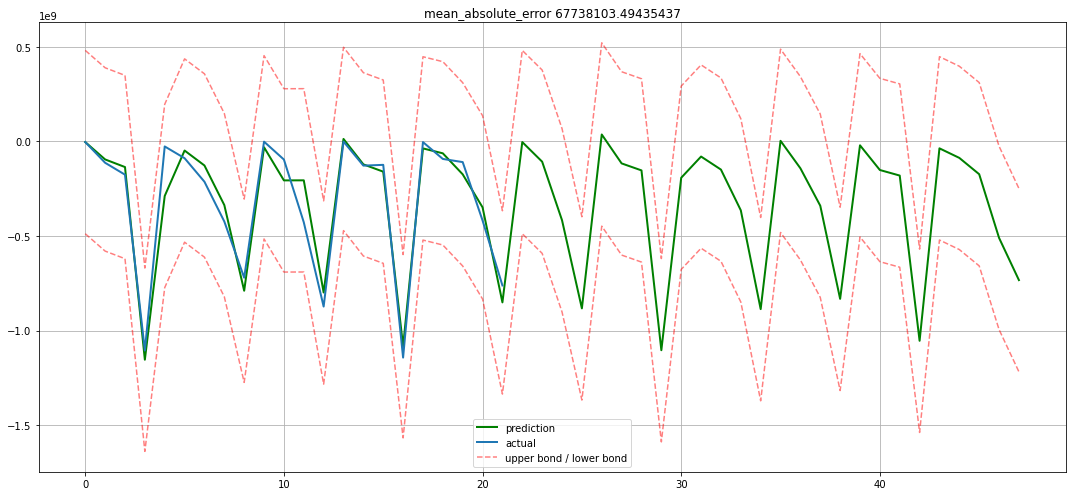

In [17]:
#0
train_align = AlignData(0)
model = XGBRegressor()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=21, model=model)
y_pred = y_pred[1:]
dfres0 = MergeVal(y_pred,0,startWeekday=2)
PosToZero(dfres0)

### Предсказания для б.ю. 1. Расчетный день - среда

In [18]:
%%capture
#1
train_align = AlignData(1)
model = XGBRegressor(random_state=42) 
print('XGBRegressor')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)
model = LinearRegression()
print('LinearRegression')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)

### Финальное предсказание для б.ю. 1. В итоге было взято значение параметра lag=4, поскольку значение MAE небольшое, не смотря на то, что берется большой отрезок

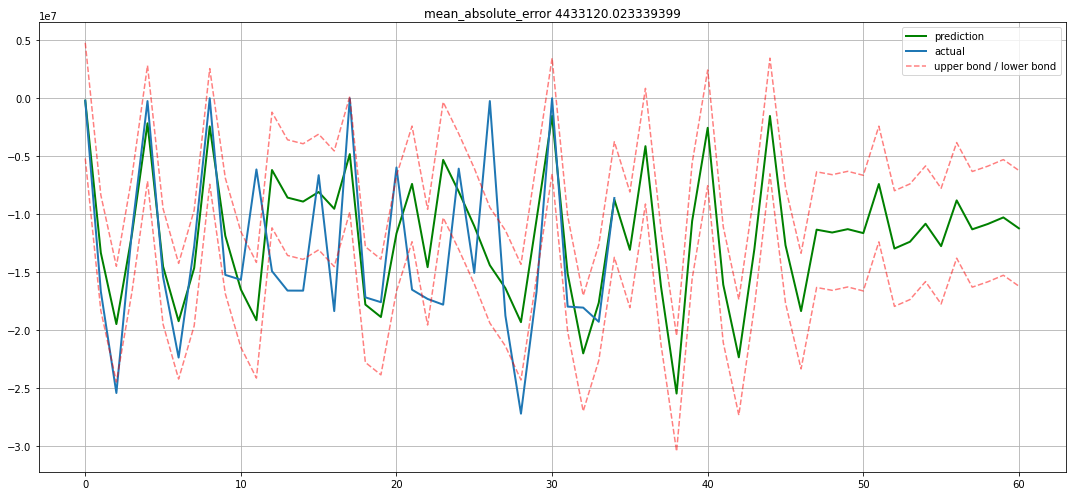

In [19]:
#1
train_align = AlignData(1)
model = XGBRegressor()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=8, model=model)
y_pred = y_pred[2:]
dfres1 = MergeVal(y_pred,1)
PosToZero(dfres1)

### Предсказания для б.ю. 2

In [20]:
%%capture
#2
train_align = AlignData(2)
model = XGBRegressor(random_state=42) 
print('XGBRegressor')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)
model = LinearRegression()
print('LinearRegression')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)

### Финальное предсказние для б.ю. 2

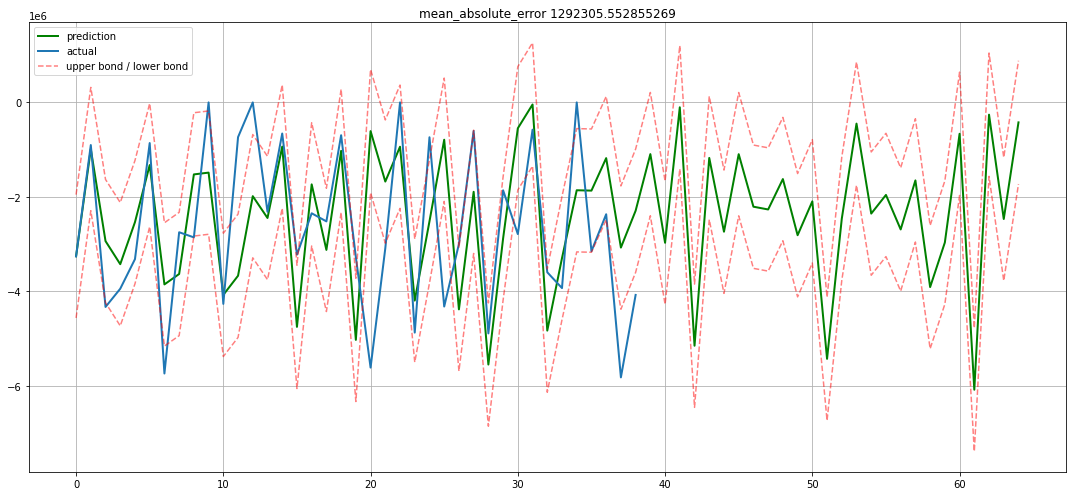

In [21]:
#2
train_align = AlignData(2)
model = XGBRegressor(random_state=40) 
#model = LinearRegression()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=4, model=model)
dfres2 = MergeVal(y_pred, 2)
PosToZero(dfres2)

### Для б.ю. 3 была построена другая модель. Нами было сделано предположение, что 21 и 14 числа каждого месяца происходит выплата определенного характера. Вместе с этим выплаты происходят в пятницу каждой недели другого характера. Предсказания были построены для каждой из этих временных последовательностей отдельно

In [22]:
train_part = train[train['БЕ']==3]
train_part.drop(['БЕ'], axis=1, inplace=True)

train_part['month'] = train_part['Дата транзакции'].dt.month
train_part['day'] = train_part['Дата транзакции'].dt.day
train_part['dayofweek'] = train_part['Дата транзакции'].dt.dayofweek

In [23]:
# извлекаем значения выплат по 21-му дню; если же это был выходной, то берем по 22 и 23 дню соответственно.
df21 = train_part.loc[np.logical_or(
    np.logical_or(
        train_part['day']==21,
        np.logical_and(train_part['day']==22,train_part['dayofweek']==0)),
    np.logical_and(train_part['day']==23,train_part['dayofweek']==0))]

df21.drop(['dayofweek','day','month','Дата транзакции'], axis=1, inplace=True)

In [24]:
# извлекаем значения выплат по 14-му дню; если же это был выходной, то берем по 15 и 16 дню соответственно.
df14part=train_part.loc[np.logical_or(
    np.logical_or(
        train_part['day']==14,
        np.logical_and(train_part['day']==15,train_part['dayofweek']==0)),
    np.logical_and(train_part['day']==16,train_part['dayofweek']==0))]

for i in range(df14part.shape[0]):
    if df14part.iloc[i,4] == 4:
        df14part.iloc[i,1] = df14part.iloc[i,1]/2  #SUGGESTION

df14 = pd.DataFrame(columns=['mth','sum'])
monthInd=1
ind = 0
while ind < df14part.shape[0]:
    if df14part.iloc[ind,2] != monthInd:
        df14=df14.append(pd.DataFrame([[monthInd, 0]], columns=['mth', 'sum']), ignore_index=True)
    else:
        df14=df14.append(pd.DataFrame([[monthInd, df14part.iloc[ind,1]]], columns=['mth', 'sum']), ignore_index=True)
        ind += 1
    monthInd += 1
    if monthInd == 13:
        monthInd=1
df14.drop(['mth'], axis=1, inplace=True)

In [25]:
# извлекаем значения выплат по пятницам
startIdx = 0
train_part = train[train['БЕ']==3]
train_part.drop(['БЕ'], axis=1, inplace=True)

train_part['dayofweek'] = train_part['Дата транзакции'].dt.dayofweek
train_part=train_part.loc[train_part['dayofweek']==4]
train_part.drop(['dayofweek'], axis=1, inplace=True)

train_align = pd.DataFrame(columns=['Дата транзакции', 'Сумма в RUB'])
prev = train_part.iloc[startIdx,0]
train_align=train_align.append(train_part.iloc[0])
ind = 1; indAlign = 1
while ind < train_part.shape[0]:
    if train_part.iloc[ind,0] - prev == timedelta(days=7):
        prev = train_part.iloc[ind,0]
        train_align = train_align.append(train_part.iloc[ind])
        ind += 1; indAlign += 1
    else :
        train_align=train_align.append(pd.DataFrame([[prev+timedelta(days=7), 0]], columns=['Дата транзакции', 'Сумма в RUB']), ignore_index=True)
        prev=prev+timedelta(days=7)
        indAlign += 1
train_align = train_align.set_index('Дата транзакции')
train_align["day"] = train_align.index.day
for i in range(train_align.shape[0]):
    if train_align.iloc[i,1]==14:
        train_align.iloc[i,0] = train_align.iloc[i,0]/2
for i in range(train_align.shape[0]):
    if train_align.iloc[i,1]==21:
        train_align.iloc[i,0] = 0
train_align.drop(['day'], axis=1, inplace=True)

In [26]:
# осуществляем предсказания для каждого временного ряда, полученного выше, используя авторег. модель
modelLin = ARModel(
    window=12,
    model=Pipeline([
        ('scaler', StandardScaler()),
        ('ar_model', LinearRegression()),
    ])
)

modelBoost= ARModel(
    window=12,
    model=Pipeline([
        ('scaler', StandardScaler()),
        ('ar_model', XGBRegressor(random_state=42)),
    ])
)
# поскольку мы строим предсказания для 6ти месяцев, то количество предсказываемых значений для каждого временного ряда есть 6,6 и 26 соответсвенно
modelBoost.fit(df21['Сумма в RUB'].values)
y_pred21 = modelBoost.forecast(6)
modelBoost.fit(df14['sum'].values)
y_pred14 = modelBoost.forecast(6)
modelBoost.fit(train_align['Сумма в RUB'].values)
y_pred4 = modelBoost.forecast(26)

In [27]:
# по некоторым дням были получены положительные предсказания - зануляем их
for i in range(len(y_pred14)):
    if y_pred14[i] > 0:
        y_pred14[i] = 0
for i in range(len(y_pred4)):
    if y_pred4[i] > 0:
        y_pred4[i] = 0

In [28]:
# объединяем полученные предсказания по датам 
prev = pd.to_datetime('2021-01-14') # четверг
dfres3 = pd.DataFrame(columns=['date','sum', 'month', 'bu'])
ind14 = 0; ind4=0; ind21 = 0;
dfres3=dfres3.append(pd.DataFrame([[prev, y_pred14[ind14],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
ind14 += 1
for dayind in range(167):
    prev=prev+timedelta(days=1)
    #print(prev, prev.day, prev.weekday())
    if prev.day == 14 and prev.weekday() ==4:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred14[ind14]+y_pred4[ind4],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind14 += 1; ind4 += 1
    elif prev.day == 21 and prev.weekday()==4:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred21[ind21],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind21 += 1; ind4 += 1
    elif prev.day == 15 and prev.weekday() ==0:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred14[ind14],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind14 += 1
    elif prev.day == 22 and prev.weekday()==0:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred21[ind21],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind21 += 1
    elif prev.day == 16 and prev.weekday() ==0:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred14[ind14],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind14 += 1
    elif prev.day == 23 and prev.weekday()==0:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred21[ind21],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind21 += 1
    elif prev.weekday() == 4:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred4[ind4],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind4 += 1
    elif prev.day == 14 and prev.weekday() < 5:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred14[ind14],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind14 += 1
    elif prev.day == 21 and prev.weekday() < 5:
        dfres3=dfres3.append(pd.DataFrame([[prev, y_pred21[ind21],prev.month,3]], columns=['date', 'sum', 'month', 'bu']), ignore_index=True)
        ind21 += 1
#dfres3 = dfres3.set_index('date')

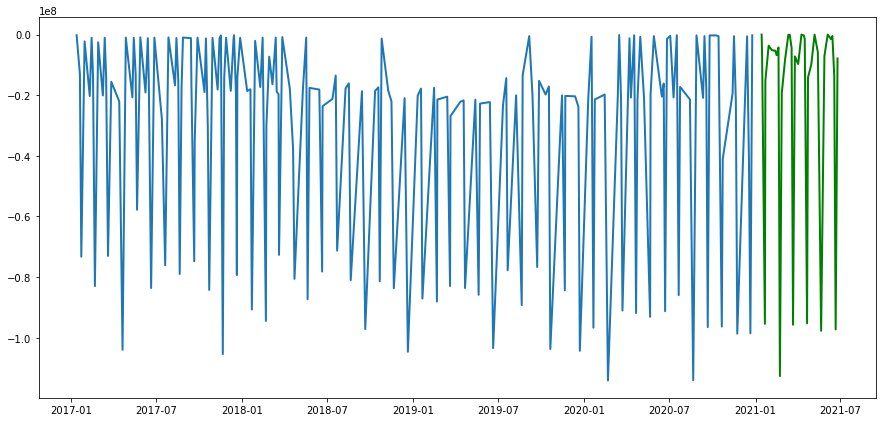

In [29]:
# строим график предсказания для 3 б.ю.
train_part = train[train['БЕ']==3]
train_part.drop(['БЕ'], axis=1, inplace=True)
train_part = train_part.set_index('Дата транзакции')
plt.figure(figsize=(15, 7))
plt.plot(dfres3.set_index('date')['sum'], "g", label="prediction", linewidth=2.0)
plt.plot(train_part, label="actual", linewidth=2.0)

### Предсказания для б.ю. 4. Расчетный день - четверг

In [30]:
%%capture
#4
train_align = AlignData(4)
model = XGBRegressor(random_state=42) 
print('XGBRegressor')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)
model = LinearRegression()
print('LinearRegression')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)

### Финальное предсказание для б.ю. 4

### Смещение на одно значение

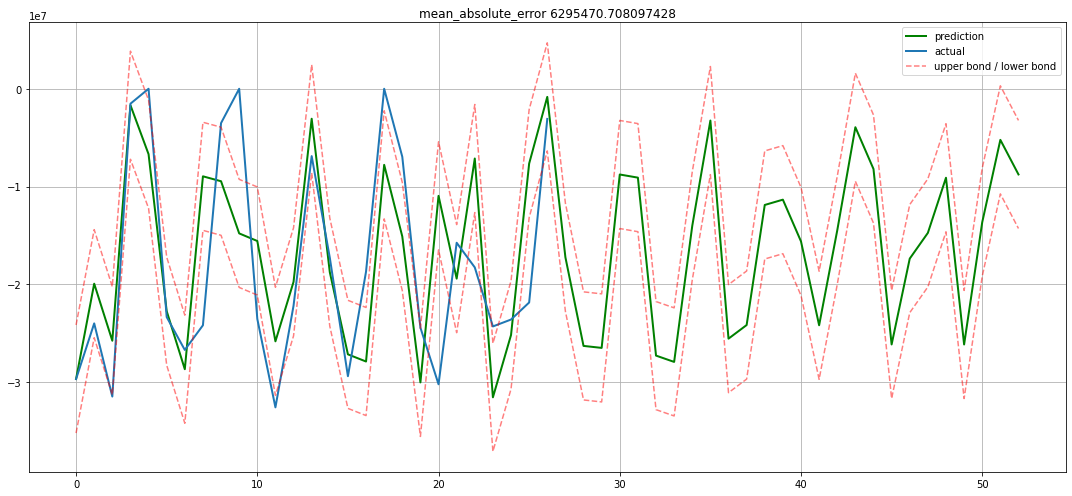

In [31]:
#4
train_align = AlignData(4)
model = XGBRegressor() 
#model = LinearRegression()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=16, model=model)
y_pred = y_pred[1:]
dfres4 = MergeVal(y_pred, 4, startWeekday=4)
PosToZero(dfres4)

### Предсказания для б.ю. 5. Расчетный день - среда

In [32]:
%%capture
#5
train_align = AlignData(5)
model = XGBRegressor(random_state=42) 
print('XGBRegressor')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)
model = LinearRegression()
print('LinearRegression')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)

### Финальное предсказание для б.ю. 5

### По б.ю. 5 делаем смещение на 2 значения. Можно делать одно смещение, но тогда добавлять дату в праздничные дни.

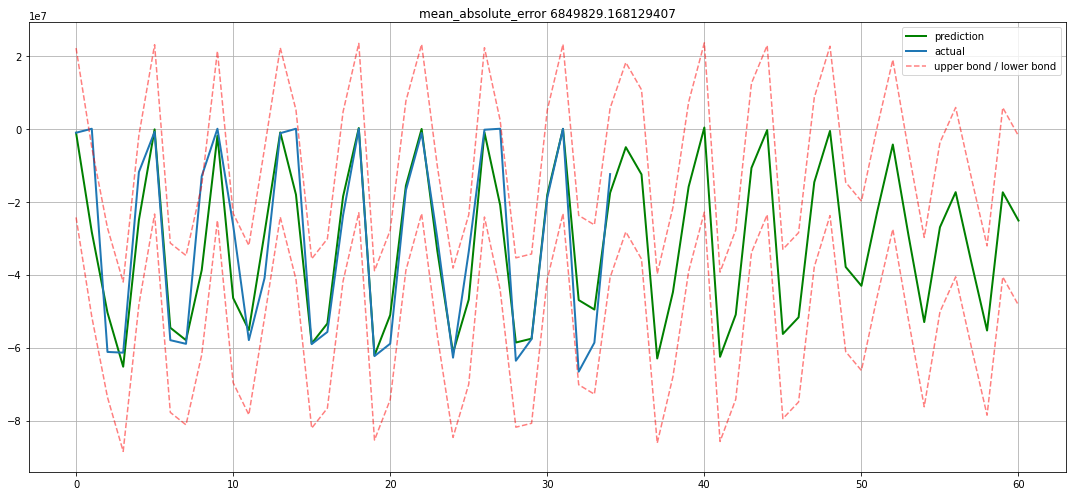

In [33]:
#5
train_align = AlignData(5)
model = XGBRegressor() 
#model = LinearRegression()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=8, model=model)
y_pred = y_pred[2:]
dfres5 = MergeVal(y_pred, 5)
PosToZero(dfres5)

### Предсказания для б.ю. 6

In [34]:
%%capture
#6
train_align = AlignData(6)
model = XGBRegressor(random_state=42) 
print('XGBRegressor')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)
model = LinearRegression()
print('LinearRegression')
for i in range(4,6):#32
    y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=i, model=model, plot=False)
    print('lag=',i,'error=',error)

### Финальное предсказание для б.ю. 6

### по 6 б.ю. стоит сдвинуть предсказанный ряд поскольку, мы выкидывали выбросы (два последних значения), и учесть первая неделя праздничная
### <u> Смущает форма графика на второй квартал</u>

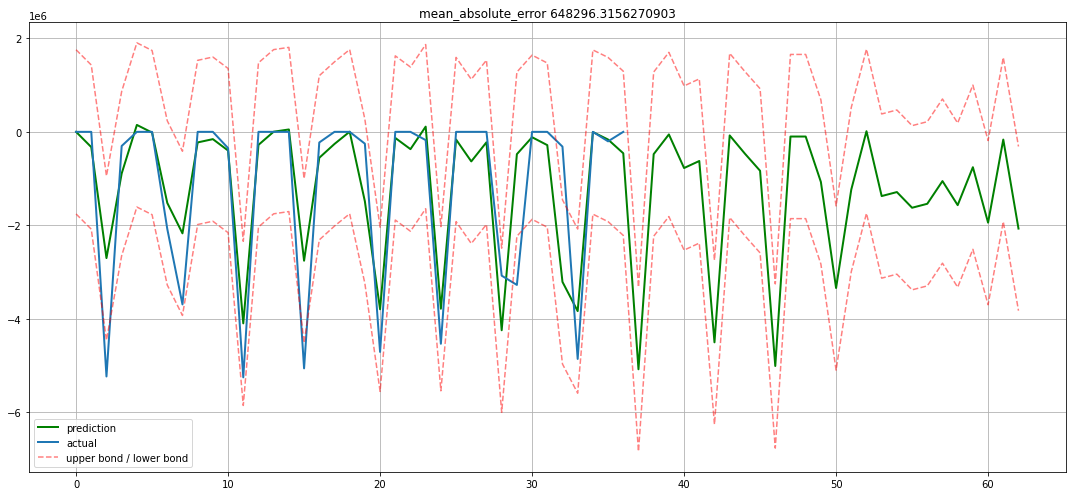

In [35]:
#6
train_align = AlignData(6)
train_align.drop(train_align.tail(2).index, inplace=True)
model = XGBRegressor() 
#model = LinearRegression()
y_pred, error = MakePlotswithPrediction(train_align=train_align,lag=6, model=model)
# смещаем y_pred, выкидывая первые значения
y_pred = y_pred[3:]
dfres6 = MergeVal(y_pred, 6)
PosToZero(dfres6)

In [36]:
frames = [dfres0,dfres1, dfres2, dfres3, dfres4, dfres5, dfres6]
res = pd.concat(frames)
res.set_index('date')
res.columns = ['Дата Транзакции','Сумма в RUB','Месяц','БЮ']
res.to_csv('results.csv') # записываем результаты в файл results.csv

In [37]:
res = pd.read_csv('results.csv',index_col='Unnamed: 0')

In [38]:
def comparePredValPlot(bu, title=''):
    res_bu = res.loc[res['БЮ']==bu]
    res_bu=res_bu.set_index('Дата Транзакции')
    res_bu.drop(['Месяц','БЮ'], axis=1, inplace=True)
    
    valid_res_bu = valid_res.loc[valid_res['БЕ']==bu]
    valid_res_bu=valid_res_bu.rename(columns={valid_res_bu.columns[2]:'Дата'})
    valid_res_bu['Дата']=pd.to_datetime(valid_res_bu['Дата'])
    valid_res_bu=valid_res_bu.set_index('Дата')
    valid_res_bu.drop(['БЕ','Период'], axis=1, inplace=True)
    data = []
    
    train_bu = train.loc[train['БЕ']==bu]
    train_bu = train_bu.iloc[-60:]
    train_bu=train_bu.set_index('Дата транзакции')
    train_bu.drop(['БЕ'], axis=1, inplace=True)
    
    title1 = {0:"pred",1:"valid",2:"train"}
    
    for idx,df in enumerate([res_bu,valid_res_bu,train_bu]):
        for column in df.columns:
            trace = go.Scatter(
                x = df.index,
                y = df[column],
                mode = 'lines',
                name = title1[idx]
            )
            data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [39]:
train_align = AlignData(5)
plotly_df(train_align)

In [40]:
comparePredValPlot(0)

In [41]:
comparePredValPlot(1)

In [42]:
comparePredValPlot(2)

In [43]:
comparePredValPlot(3)

In [44]:
comparePredValPlot(4)

In [45]:
comparePredValPlot(5)

In [46]:
comparePredValPlot(6)

### можно наблюдать смещения для б.ю. 6, 5, 0, 4, 1 - выявить причину. 3 - не выдает ничего. 2 - не понятно. <u> Нужно объяснить природу смещений </u>

### <u> прокомментировать результата, опираясь на графики, стат. показатели и бизнес сенс</u>  - показать, что полученная модель хорошо предсказывает большие платежи (можно попробоавть сделать на это упор)

### <u> Сравнить результаты по дням недели и выявить несоответствия. Обратить внимание на майские праздники (важно для предсказания на второй квартал)</u>

In [59]:
def mae_monthly(X_df, y_df):
    y_df['Расчет ликвидности - дата'] = pd.to_datetime(y_df['Расчет ликвидности - дата'])
    y_df = y_df.rename({'Расчет ликвидности - дата': 'date', 'Сумма в валюте транзакции':'sum'}, axis=1)
    #y_df['cumsum'] = y_df.groupby(by=['Период'])['Сумма в валюте транзакции'].cumsum()
    
    #X_df['period'] = X_df['date'].dt.month
    #X_df['cumsum'] = X_df.groupby(by=['period'])['sum'].cumsum()
    
    merged_df = X_df[['date', 'sum']].merge(y_df[['date', 'sum']], on='date', how='outer').fillna(0).sort_values(by=['date'], ascending=True)
    merged_df['period'] = merged_df['date'].dt.month
    merged_df['x_cumsum'] = merged_df.groupby(by=['period'])['sum_x'].cumsum()
    merged_df['y_cumsum'] = merged_df.groupby(by=['period'])['sum_y'].cumsum()
    mae_list = []
    for i in range(1,max(merged_df['period']),1):
        filtered_merged_df = merged_df[merged_df['period']==i]
        mae_list.append(mean_absolute_error(filtered_merged_df['x_cumsum'], filtered_merged_df['y_cumsum']))
    return np.mean(mae_list)

mae_monthly(dfres6.copy(), valid_res[valid_res['БЕ']==0].copy())

353028965.4460642

In [51]:
def final_output(df):
    df = df[['bu', 'month', 'date', 'sum']]
    df['cumsum'] = df.groupby(by=['month'])['sum'].cumsum()
    df = df[['bu', 'month', 'date', 'cumsum']]
    df.columns = ['БЕ','Период','Расчет ликвидности - дата','Сумма в валюте транзакции']
    return df

In [52]:
dfres00 = final_output(dfres0)
dfres11 = final_output(dfres1)
dfres22 = final_output(dfres2)
dfres33 = final_output(dfres3)
dfres44 = final_output(dfres4)
dfres55 = final_output(dfres5)
dfres66 = final_output(dfres6)
frames_new = [dfres00, dfres11, dfres22, dfres33, dfres44, dfres55, dfres66]
res_new = pd.concat(frames_new)
res_new.to_csv('results_final.csv') # записываем результаты в файл results.csv

In [47]:
def comparePredVal(bu, title=''):
    res_bu = res.loc[res['БЮ']==bu]
    res_bu=res_bu.set_index('Дата Транзакции')
    res_bu.drop(['Месяц','БЮ'], axis=1, inplace=True)
    res_bu.index = pd.to_datetime(res_bu.index)
    res_bu['dayofweek']=res_bu.index.dayofweek
    
    valid_res_bu = valid_res.loc[valid_res['БЕ']==bu]
    valid_res_bu=valid_res_bu.rename(columns={valid_res_bu.columns[2]:'Дата'})
    valid_res_bu['Дата']=pd.to_datetime(valid_res_bu['Дата'])
    valid_res_bu=valid_res_bu.set_index('Дата')
    valid_res_bu.drop(['БЕ','Период'], axis=1, inplace=True)
    valid_res_bu['dayofweek']=valid_res_bu.index.dayofweek
    
    train_bu = train.loc[train['БЕ']==bu]
    train_bu = train_bu.iloc[-60:]
    train_bu=train_bu.set_index('Дата транзакции')
    train_bu.drop(['БЕ'], axis=1, inplace=True)
    
    return res_bu, valid_res_bu